# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 100000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 3000
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 256
test.transforms = ToTensor() 256


## Confirm that the dataset is loaded properly

In [6]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([0.4882, 0.4763, 0.4405])
Shape of y: torch.Size([256]) torch.int64


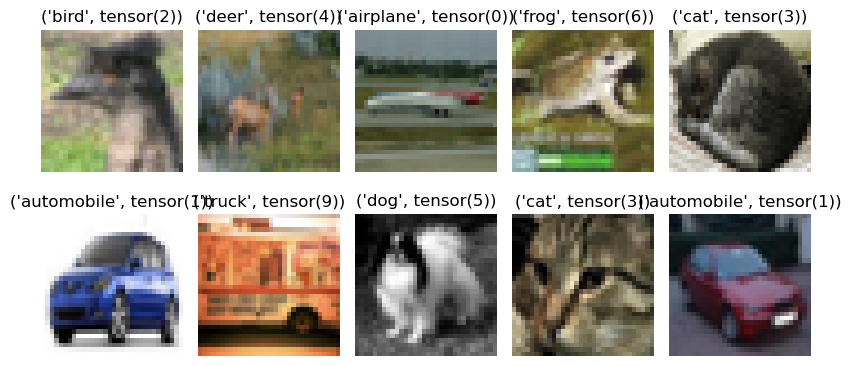

In [7]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [10]:
model.named_modules

<bound method Module.named_modules of MyResNet_CIFAR(
  (single_conv32block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv32blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv

In [11]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 0.464M                 | 18.018G    |
|  single_conv32block            |  0.464K                |  0.134G    |
|   single_conv32block.0         |   0.432K               |   0.113G   |
|    single_conv32block.0.weight |    (16, 3, 3, 3)       |            |
|   single_conv32block.1         |   32                   |   20.972M  |
|    single_conv32block.1.weight |    (16,)               |            |
|    single_conv32block.1.bias   |    (16,)               |            |
|  conv32blocks                  |  23.36K                |  6.25G     |
|   conv32blocks.0               |   4.672K               |   1.25G    |
|    conv32blocks.0.conv1        |    2.304K              |    0.604G  |
|    conv32blocks.0.bn1          |    32                  |    20.972M |
|    conv32blocks.0.conv2        |    2.304K       

# Define Training

## (1) Define Criterion

In [12]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [13]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience, model, file_path):
        self.best_eval_loss = float("inf")
        self.early_stop_counter = 0
        self.PATIENCE = patience
        self.file_path = file_path
        self.model = model
        pass

    def check(self, eval_loss):
        if eval_loss < self.best_eval_loss:
            self.best_eval_loss = eval_loss
            self.early_stop_counter = 0
            print("updated best eval loss :", self.best_eval_loss)
            torch.save(self.model.state_dict(), "models/" + self.file_path + ".pth")
            return False
        else:
            self.early_stop_counter += 1
            if self.early_stop_counter >= self.PATIENCE:
                print(f"Early stop!! best_eval_loss = {self.best_eval_loss}")
                return True
                
    def state_dict(self):
        return {"best_eval_loss": self.best_eval_loss, "early_stop_counter": self.early_stop_counter}
    
    def load_state_dict(self, state_dict):
        self.best_eval_loss = state_dict["best_eval_loss"]
        self.early_stop_counter = state_dict["early_stop_counter"]
        
        return
    
earlystopper = EarlyStopper(EARLYSTOPPINGPATIENCE, model, file_path)

## (4) Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR10": 1000, "CIFAR100": 1000, "ImageNet2012": 30}

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=100
)

## (5) Define AMP scaler

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [18]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100000] :


100%|██████████| 196/196 [00:05<00:00, 38.09it/s]


Train Loss: 0.0111 | Train Acc: 18.75%
Test  Loss: 2.1625 | Test Acc: 18.33%
updated best eval loss : 2.162518972158432
--------------------------------------------------
[Epoch 2/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.47it/s]


Train Loss: 0.0096 | Train Acc: 28.75%
Test  Loss: 1.9983 | Test Acc: 27.47%
updated best eval loss : 1.9982523679733277
--------------------------------------------------
[Epoch 3/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.23it/s]


Train Loss: 0.0095 | Train Acc: 33.75%
Test  Loss: 2.2136 | Test Acc: 25.40%
--------------------------------------------------
[Epoch 4/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.45it/s]


Train Loss: 0.0082 | Train Acc: 42.50%
Test  Loss: 1.7073 | Test Acc: 40.02%
updated best eval loss : 1.7072778820991517
--------------------------------------------------
[Epoch 5/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.01it/s]


Train Loss: 0.0080 | Train Acc: 42.50%
Test  Loss: 1.3336 | Test Acc: 52.64%
updated best eval loss : 1.3335732519626617
--------------------------------------------------
[Epoch 6/100000] :


100%|██████████| 196/196 [00:07<00:00, 28.00it/s]


Train Loss: 0.0068 | Train Acc: 48.75%
Test  Loss: 1.2601 | Test Acc: 56.34%
updated best eval loss : 1.260052067041397
--------------------------------------------------
[Epoch 7/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.93it/s]


Train Loss: 0.0059 | Train Acc: 57.50%
Test  Loss: 1.0625 | Test Acc: 63.04%
updated best eval loss : 1.062529706954956
--------------------------------------------------
[Epoch 8/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.07it/s]


Train Loss: 0.0053 | Train Acc: 60.00%
Test  Loss: 0.8402 | Test Acc: 70.60%
updated best eval loss : 0.8401910796761513
--------------------------------------------------
[Epoch 9/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.48it/s]


Train Loss: 0.0044 | Train Acc: 65.00%
Test  Loss: 0.9675 | Test Acc: 66.98%
--------------------------------------------------
[Epoch 10/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.62it/s]


Train Loss: 0.0045 | Train Acc: 68.75%
Test  Loss: 0.7901 | Test Acc: 72.32%
updated best eval loss : 0.7901070177555084
--------------------------------------------------
[Epoch 11/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.04it/s]


Train Loss: 0.0063 | Train Acc: 61.25%
Test  Loss: 0.8964 | Test Acc: 69.87%
--------------------------------------------------
[Epoch 12/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.46it/s]


Train Loss: 0.0044 | Train Acc: 80.00%
Test  Loss: 0.7577 | Test Acc: 74.65%
updated best eval loss : 0.7577084854245186
--------------------------------------------------
[Epoch 13/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.63it/s]


Train Loss: 0.0034 | Train Acc: 77.50%
Test  Loss: 0.7741 | Test Acc: 74.35%
--------------------------------------------------
[Epoch 14/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.07it/s]


Train Loss: 0.0036 | Train Acc: 75.00%
Test  Loss: 0.6640 | Test Acc: 76.91%
updated best eval loss : 0.6640306249260902
--------------------------------------------------
[Epoch 15/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.24it/s]


Train Loss: 0.0058 | Train Acc: 58.75%
Test  Loss: 0.6884 | Test Acc: 76.85%
--------------------------------------------------
[Epoch 16/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.01it/s]


Train Loss: 0.0049 | Train Acc: 65.00%
Test  Loss: 0.7129 | Test Acc: 75.36%
--------------------------------------------------
[Epoch 17/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.13it/s]


Train Loss: 0.0045 | Train Acc: 67.50%
Test  Loss: 0.6292 | Test Acc: 78.54%
updated best eval loss : 0.6291769005358219
--------------------------------------------------
[Epoch 18/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.03it/s]


Train Loss: 0.0034 | Train Acc: 81.25%
Test  Loss: 0.6409 | Test Acc: 77.60%
--------------------------------------------------
[Epoch 19/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.23it/s]


Train Loss: 0.0032 | Train Acc: 76.25%
Test  Loss: 0.9851 | Test Acc: 69.83%
--------------------------------------------------
[Epoch 20/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.10it/s]


Train Loss: 0.0036 | Train Acc: 77.50%
Test  Loss: 0.5876 | Test Acc: 80.20%
updated best eval loss : 0.587640642374754
--------------------------------------------------
[Epoch 21/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.89it/s]


Train Loss: 0.0039 | Train Acc: 75.00%
Test  Loss: 0.7235 | Test Acc: 75.87%
--------------------------------------------------
[Epoch 22/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.86it/s]


Train Loss: 0.0036 | Train Acc: 75.00%
Test  Loss: 0.6029 | Test Acc: 79.32%
--------------------------------------------------
[Epoch 23/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.75it/s]


Train Loss: 0.0035 | Train Acc: 76.25%
Test  Loss: 0.8262 | Test Acc: 74.27%
--------------------------------------------------
[Epoch 24/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.16it/s]


Train Loss: 0.0040 | Train Acc: 73.75%
Test  Loss: 0.5958 | Test Acc: 79.93%
--------------------------------------------------
[Epoch 25/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.74it/s]


Train Loss: 0.0037 | Train Acc: 72.50%
Test  Loss: 0.6319 | Test Acc: 78.79%
--------------------------------------------------
[Epoch 26/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.50it/s]


Train Loss: 0.0041 | Train Acc: 76.25%
Test  Loss: 0.5252 | Test Acc: 82.15%
updated best eval loss : 0.525245013833046
--------------------------------------------------
[Epoch 27/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.29it/s]


Train Loss: 0.0037 | Train Acc: 75.00%
Test  Loss: 0.5271 | Test Acc: 81.81%
--------------------------------------------------
[Epoch 28/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.23it/s]


Train Loss: 0.0033 | Train Acc: 77.50%
Test  Loss: 0.5121 | Test Acc: 82.46%
updated best eval loss : 0.5120787359774113
--------------------------------------------------
[Epoch 29/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.54it/s]


Train Loss: 0.0046 | Train Acc: 65.00%
Test  Loss: 0.5569 | Test Acc: 81.44%
--------------------------------------------------
[Epoch 30/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.11it/s]


Train Loss: 0.0043 | Train Acc: 63.75%
Test  Loss: 0.4946 | Test Acc: 83.19%
updated best eval loss : 0.49464104920625684
--------------------------------------------------
[Epoch 31/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.68it/s]


Train Loss: 0.0033 | Train Acc: 78.75%
Test  Loss: 0.5307 | Test Acc: 81.92%
--------------------------------------------------
[Epoch 32/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.25it/s]


Train Loss: 0.0034 | Train Acc: 77.50%
Test  Loss: 0.5796 | Test Acc: 80.29%
--------------------------------------------------
[Epoch 33/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.15it/s]


Train Loss: 0.0030 | Train Acc: 78.75%
Test  Loss: 0.5570 | Test Acc: 81.01%
--------------------------------------------------
[Epoch 34/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.68it/s]


Train Loss: 0.0031 | Train Acc: 82.50%
Test  Loss: 0.4902 | Test Acc: 83.13%
updated best eval loss : 0.49022269546985625
--------------------------------------------------
[Epoch 35/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.11it/s]


Train Loss: 0.0024 | Train Acc: 78.75%
Test  Loss: 0.6148 | Test Acc: 79.84%
--------------------------------------------------
[Epoch 36/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.11it/s]


Train Loss: 0.0040 | Train Acc: 72.50%
Test  Loss: 0.5353 | Test Acc: 81.80%
--------------------------------------------------
[Epoch 37/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.80it/s]


Train Loss: 0.0024 | Train Acc: 88.75%
Test  Loss: 0.4929 | Test Acc: 82.90%
--------------------------------------------------
[Epoch 38/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.38it/s]


Train Loss: 0.0033 | Train Acc: 83.75%
Test  Loss: 0.5318 | Test Acc: 82.73%
--------------------------------------------------
[Epoch 39/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.49it/s]


Train Loss: 0.0037 | Train Acc: 75.00%
Test  Loss: 0.5287 | Test Acc: 82.52%
--------------------------------------------------
[Epoch 40/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.83it/s]


Train Loss: 0.0032 | Train Acc: 81.25%
Test  Loss: 0.6427 | Test Acc: 79.46%
--------------------------------------------------
[Epoch 41/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.93it/s]


Train Loss: 0.0025 | Train Acc: 80.00%
Test  Loss: 0.4513 | Test Acc: 84.59%
updated best eval loss : 0.4512861169874668
--------------------------------------------------
[Epoch 42/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.82it/s]


Train Loss: 0.0034 | Train Acc: 76.25%
Test  Loss: 0.4501 | Test Acc: 84.70%
updated best eval loss : 0.4500766254961491
--------------------------------------------------
[Epoch 43/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.58it/s]


Train Loss: 0.0046 | Train Acc: 68.75%
Test  Loss: 0.5045 | Test Acc: 82.85%
--------------------------------------------------
[Epoch 44/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.77it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Test  Loss: 0.4536 | Test Acc: 84.35%
--------------------------------------------------
[Epoch 45/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.77it/s]


Train Loss: 0.0026 | Train Acc: 86.25%
Test  Loss: 0.4543 | Test Acc: 84.68%
--------------------------------------------------
[Epoch 46/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.69it/s]


Train Loss: 0.0030 | Train Acc: 86.25%
Test  Loss: 0.5827 | Test Acc: 81.21%
--------------------------------------------------
[Epoch 47/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.97it/s]


Train Loss: 0.0032 | Train Acc: 78.75%
Test  Loss: 0.5009 | Test Acc: 83.75%
--------------------------------------------------
[Epoch 48/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.10it/s]


Train Loss: 0.0026 | Train Acc: 82.50%
Test  Loss: 0.4594 | Test Acc: 83.96%
--------------------------------------------------
[Epoch 49/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.37it/s]


Train Loss: 0.0035 | Train Acc: 77.50%
Test  Loss: 0.4471 | Test Acc: 84.87%
updated best eval loss : 0.44710563868284225
--------------------------------------------------
[Epoch 50/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.18it/s]


Train Loss: 0.0028 | Train Acc: 78.75%
Test  Loss: 0.4307 | Test Acc: 85.29%
updated best eval loss : 0.4307476969435811
--------------------------------------------------
[Epoch 51/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.75it/s]


Train Loss: 0.0044 | Train Acc: 66.25%
Test  Loss: 0.4871 | Test Acc: 83.93%
--------------------------------------------------
[Epoch 52/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.68it/s]


Train Loss: 0.0026 | Train Acc: 85.00%
Test  Loss: 0.4561 | Test Acc: 85.28%
--------------------------------------------------
[Epoch 53/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.80it/s]


Train Loss: 0.0038 | Train Acc: 72.50%
Test  Loss: 0.4140 | Test Acc: 86.49%
updated best eval loss : 0.41404549553990366
--------------------------------------------------
[Epoch 54/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.00it/s]


Train Loss: 0.0031 | Train Acc: 80.00%
Test  Loss: 0.4615 | Test Acc: 84.36%
--------------------------------------------------
[Epoch 55/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.89it/s]


Train Loss: 0.0030 | Train Acc: 81.25%
Test  Loss: 0.4854 | Test Acc: 83.52%
--------------------------------------------------
[Epoch 56/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.24it/s]


Train Loss: 0.0043 | Train Acc: 71.25%
Test  Loss: 0.4433 | Test Acc: 84.70%
--------------------------------------------------
[Epoch 57/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.74it/s]


Train Loss: 0.0029 | Train Acc: 80.00%
Test  Loss: 0.4173 | Test Acc: 85.66%
--------------------------------------------------
[Epoch 58/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.60it/s]


Train Loss: 0.0021 | Train Acc: 91.25%
Test  Loss: 0.4311 | Test Acc: 85.74%
--------------------------------------------------
[Epoch 59/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.42it/s]


Train Loss: 0.0025 | Train Acc: 85.00%
Test  Loss: 0.4149 | Test Acc: 85.98%
--------------------------------------------------
[Epoch 60/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.65it/s]


Train Loss: 0.0024 | Train Acc: 87.50%
Test  Loss: 0.5034 | Test Acc: 82.86%
--------------------------------------------------
[Epoch 61/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.06it/s]


Train Loss: 0.0030 | Train Acc: 76.25%
Test  Loss: 0.4197 | Test Acc: 85.65%
--------------------------------------------------
[Epoch 62/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.59it/s]


Train Loss: 0.0030 | Train Acc: 78.75%
Test  Loss: 0.5189 | Test Acc: 82.28%
--------------------------------------------------
[Epoch 63/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Loss: 0.0040 | Train Acc: 76.25%
Test  Loss: 0.4238 | Test Acc: 85.44%
--------------------------------------------------
[Epoch 64/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.82it/s]


Train Loss: 0.0026 | Train Acc: 81.25%
Test  Loss: 0.4120 | Test Acc: 85.99%
updated best eval loss : 0.411991561204195
--------------------------------------------------
[Epoch 65/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.21it/s]


Train Loss: 0.0022 | Train Acc: 87.50%
Test  Loss: 0.5038 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 66/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.52it/s]


Train Loss: 0.0027 | Train Acc: 82.50%
Test  Loss: 0.4152 | Test Acc: 85.98%
--------------------------------------------------
[Epoch 67/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.55it/s]


Train Loss: 0.0031 | Train Acc: 81.25%
Test  Loss: 0.5068 | Test Acc: 83.09%
--------------------------------------------------
[Epoch 68/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.22it/s]


Train Loss: 0.0030 | Train Acc: 83.75%
Test  Loss: 0.5082 | Test Acc: 83.38%
--------------------------------------------------
[Epoch 69/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.69it/s]


Train Loss: 0.0028 | Train Acc: 78.75%
Test  Loss: 0.4402 | Test Acc: 85.52%
--------------------------------------------------
[Epoch 70/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.21it/s]


Train Loss: 0.0026 | Train Acc: 85.00%
Test  Loss: 0.4519 | Test Acc: 85.35%
--------------------------------------------------
[Epoch 71/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.86it/s]


Train Loss: 0.0029 | Train Acc: 81.25%
Test  Loss: 0.4276 | Test Acc: 86.03%
--------------------------------------------------
[Epoch 72/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.28it/s]


Train Loss: 0.0031 | Train Acc: 76.25%
Test  Loss: 0.3946 | Test Acc: 86.30%
updated best eval loss : 0.3946429803967476
--------------------------------------------------
[Epoch 73/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.37it/s]


Train Loss: 0.0023 | Train Acc: 82.50%
Test  Loss: 0.4114 | Test Acc: 86.25%
--------------------------------------------------
[Epoch 74/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.69it/s]


Train Loss: 0.0022 | Train Acc: 83.75%
Test  Loss: 0.4250 | Test Acc: 85.78%
--------------------------------------------------
[Epoch 75/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.38it/s]


Train Loss: 0.0028 | Train Acc: 83.75%
Test  Loss: 0.4227 | Test Acc: 86.04%
--------------------------------------------------
[Epoch 76/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.63it/s]


Train Loss: 0.0038 | Train Acc: 70.00%
Test  Loss: 0.5094 | Test Acc: 83.95%
--------------------------------------------------
[Epoch 77/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.74it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.4004 | Test Acc: 86.18%
--------------------------------------------------
[Epoch 78/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.72it/s]


Train Loss: 0.0030 | Train Acc: 76.25%
Test  Loss: 0.4204 | Test Acc: 86.10%
--------------------------------------------------
[Epoch 79/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.06it/s]


Train Loss: 0.0037 | Train Acc: 72.50%
Test  Loss: 0.4284 | Test Acc: 86.24%
--------------------------------------------------
[Epoch 80/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.51it/s]


Train Loss: 0.0028 | Train Acc: 83.75%
Test  Loss: 0.4044 | Test Acc: 86.63%
--------------------------------------------------
[Epoch 81/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.03it/s]


Train Loss: 0.0024 | Train Acc: 83.75%
Test  Loss: 0.4216 | Test Acc: 85.97%
--------------------------------------------------
[Epoch 82/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.08it/s]


Train Loss: 0.0045 | Train Acc: 71.25%
Test  Loss: 0.3943 | Test Acc: 86.55%
updated best eval loss : 0.3943069614470005
--------------------------------------------------
[Epoch 83/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.13it/s]


Train Loss: 0.0031 | Train Acc: 82.50%
Test  Loss: 0.6696 | Test Acc: 80.22%
--------------------------------------------------
[Epoch 84/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.69it/s]


Train Loss: 0.0025 | Train Acc: 81.25%
Test  Loss: 0.4176 | Test Acc: 86.38%
--------------------------------------------------
[Epoch 85/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.35it/s]


Train Loss: 0.0028 | Train Acc: 83.75%
Test  Loss: 0.5415 | Test Acc: 82.55%
--------------------------------------------------
[Epoch 86/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.74it/s]


Train Loss: 0.0016 | Train Acc: 88.75%
Test  Loss: 0.4578 | Test Acc: 84.65%
--------------------------------------------------
[Epoch 87/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.98it/s]


Train Loss: 0.0026 | Train Acc: 81.25%
Test  Loss: 0.3527 | Test Acc: 87.81%
updated best eval loss : 0.3526645299047232
--------------------------------------------------
[Epoch 88/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.49it/s]


Train Loss: 0.0025 | Train Acc: 80.00%
Test  Loss: 0.4214 | Test Acc: 85.66%
--------------------------------------------------
[Epoch 89/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.29it/s]


Train Loss: 0.0029 | Train Acc: 80.00%
Test  Loss: 0.4690 | Test Acc: 85.11%
--------------------------------------------------
[Epoch 90/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.56it/s]


Train Loss: 0.0031 | Train Acc: 80.00%
Test  Loss: 0.4025 | Test Acc: 86.01%
--------------------------------------------------
[Epoch 91/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.41it/s]


Train Loss: 0.0022 | Train Acc: 88.75%
Test  Loss: 0.4979 | Test Acc: 83.65%
--------------------------------------------------
[Epoch 92/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.31it/s]


Train Loss: 0.0024 | Train Acc: 80.00%
Test  Loss: 0.4277 | Test Acc: 85.81%
--------------------------------------------------
[Epoch 93/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.24it/s]


Train Loss: 0.0026 | Train Acc: 87.50%
Test  Loss: 0.4025 | Test Acc: 86.93%
--------------------------------------------------
[Epoch 94/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.80it/s]


Train Loss: 0.0026 | Train Acc: 86.25%
Test  Loss: 0.3739 | Test Acc: 87.43%
--------------------------------------------------
[Epoch 95/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.88it/s]


Train Loss: 0.0025 | Train Acc: 81.25%
Test  Loss: 0.4549 | Test Acc: 84.94%
--------------------------------------------------
[Epoch 96/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.59it/s]


Train Loss: 0.0022 | Train Acc: 86.25%
Test  Loss: 0.3689 | Test Acc: 87.90%
--------------------------------------------------
[Epoch 97/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.50it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.4549 | Test Acc: 84.43%
--------------------------------------------------
[Epoch 98/100000] :


100%|██████████| 196/196 [00:07<00:00, 28.00it/s]


Train Loss: 0.0029 | Train Acc: 77.50%
Test  Loss: 0.4018 | Test Acc: 86.65%
--------------------------------------------------
[Epoch 99/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.79it/s]


Train Loss: 0.0020 | Train Acc: 86.25%
Test  Loss: 0.4125 | Test Acc: 86.33%
--------------------------------------------------
[Epoch 100/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.59it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.4385 | Test Acc: 85.62%
--------------------------------------------------
[Epoch 101/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.52it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.3530 | Test Acc: 88.11%
--------------------------------------------------
[Epoch 102/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.24it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.3764 | Test Acc: 87.58%
--------------------------------------------------
[Epoch 103/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.00it/s]


Train Loss: 0.0017 | Train Acc: 85.00%
Test  Loss: 0.3730 | Test Acc: 87.59%
--------------------------------------------------
[Epoch 104/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.92it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Test  Loss: 0.4341 | Test Acc: 85.63%
--------------------------------------------------
[Epoch 105/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.46it/s]


Train Loss: 0.0028 | Train Acc: 78.75%
Test  Loss: 0.4548 | Test Acc: 85.69%
--------------------------------------------------
[Epoch 106/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.41it/s]


Train Loss: 0.0032 | Train Acc: 76.25%
Test  Loss: 0.3875 | Test Acc: 87.24%
--------------------------------------------------
[Epoch 107/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.04it/s]


Train Loss: 0.0024 | Train Acc: 81.25%
Test  Loss: 0.3711 | Test Acc: 87.57%
--------------------------------------------------
[Epoch 108/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.35it/s]


Train Loss: 0.0032 | Train Acc: 85.00%
Test  Loss: 0.5120 | Test Acc: 83.47%
--------------------------------------------------
[Epoch 109/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.41it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.4215 | Test Acc: 86.56%
--------------------------------------------------
[Epoch 110/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.13it/s]


Train Loss: 0.0017 | Train Acc: 85.00%
Test  Loss: 0.4953 | Test Acc: 84.29%
--------------------------------------------------
[Epoch 111/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.53it/s]


Train Loss: 0.0028 | Train Acc: 78.75%
Test  Loss: 0.3851 | Test Acc: 87.42%
--------------------------------------------------
[Epoch 112/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.22it/s]


Train Loss: 0.0022 | Train Acc: 83.75%
Test  Loss: 0.4091 | Test Acc: 86.21%
--------------------------------------------------
[Epoch 113/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.01it/s]


Train Loss: 0.0018 | Train Acc: 83.75%
Test  Loss: 0.4221 | Test Acc: 86.36%
--------------------------------------------------
[Epoch 114/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.99it/s]


Train Loss: 0.0025 | Train Acc: 82.50%
Test  Loss: 0.3520 | Test Acc: 87.84%
updated best eval loss : 0.351992853730917
--------------------------------------------------
[Epoch 115/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.94it/s]


Train Loss: 0.0029 | Train Acc: 78.75%
Test  Loss: 0.3950 | Test Acc: 87.06%
--------------------------------------------------
[Epoch 116/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.32it/s]


Train Loss: 0.0028 | Train Acc: 80.00%
Test  Loss: 0.4809 | Test Acc: 84.63%
--------------------------------------------------
[Epoch 117/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.13it/s]


Train Loss: 0.0020 | Train Acc: 86.25%
Test  Loss: 0.4223 | Test Acc: 86.91%
--------------------------------------------------
[Epoch 118/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.77it/s]


Train Loss: 0.0018 | Train Acc: 92.50%
Test  Loss: 0.3984 | Test Acc: 87.53%
--------------------------------------------------
[Epoch 119/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.12it/s]


Train Loss: 0.0020 | Train Acc: 81.25%
Test  Loss: 0.3153 | Test Acc: 89.24%
updated best eval loss : 0.31533361971378326
--------------------------------------------------
[Epoch 120/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.48it/s]


Train Loss: 0.0017 | Train Acc: 85.00%
Test  Loss: 0.4023 | Test Acc: 86.37%
--------------------------------------------------
[Epoch 121/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.15it/s]


Train Loss: 0.0036 | Train Acc: 80.00%
Test  Loss: 0.4616 | Test Acc: 85.11%
--------------------------------------------------
[Epoch 122/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.15it/s]


Train Loss: 0.0028 | Train Acc: 77.50%
Test  Loss: 0.3377 | Test Acc: 87.97%
--------------------------------------------------
[Epoch 123/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.56it/s]


Train Loss: 0.0028 | Train Acc: 77.50%
Test  Loss: 0.3724 | Test Acc: 87.59%
--------------------------------------------------
[Epoch 124/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.46it/s]


Train Loss: 0.0027 | Train Acc: 76.25%
Test  Loss: 0.3723 | Test Acc: 87.31%
--------------------------------------------------
[Epoch 125/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.72it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Test  Loss: 0.3541 | Test Acc: 87.93%
--------------------------------------------------
[Epoch 126/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.33it/s]


Train Loss: 0.0028 | Train Acc: 76.25%
Test  Loss: 0.3527 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 127/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.59it/s]


Train Loss: 0.0021 | Train Acc: 83.75%
Test  Loss: 0.4093 | Test Acc: 86.18%
--------------------------------------------------
[Epoch 128/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.21it/s]


Train Loss: 0.0023 | Train Acc: 83.75%
Test  Loss: 0.3659 | Test Acc: 87.62%
--------------------------------------------------
[Epoch 129/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.71it/s]


Train Loss: 0.0027 | Train Acc: 80.00%
Test  Loss: 0.4427 | Test Acc: 85.93%
--------------------------------------------------
[Epoch 130/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.65it/s]


Train Loss: 0.0044 | Train Acc: 66.25%
Test  Loss: 0.4015 | Test Acc: 86.94%
--------------------------------------------------
[Epoch 131/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.50it/s]


Train Loss: 0.0030 | Train Acc: 72.50%
Test  Loss: 0.4129 | Test Acc: 86.40%
--------------------------------------------------
[Epoch 132/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.62it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.4172 | Test Acc: 86.36%
--------------------------------------------------
[Epoch 133/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.67it/s]


Train Loss: 0.0025 | Train Acc: 85.00%
Test  Loss: 0.3479 | Test Acc: 88.34%
--------------------------------------------------
[Epoch 134/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.49it/s]


Train Loss: 0.0019 | Train Acc: 86.25%
Test  Loss: 0.3307 | Test Acc: 88.26%
--------------------------------------------------
[Epoch 135/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.72it/s]


Train Loss: 0.0030 | Train Acc: 80.00%
Test  Loss: 0.3535 | Test Acc: 88.53%
--------------------------------------------------
[Epoch 136/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.61it/s]


Train Loss: 0.0027 | Train Acc: 77.50%
Test  Loss: 0.3644 | Test Acc: 87.88%
--------------------------------------------------
[Epoch 137/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.66it/s]


Train Loss: 0.0019 | Train Acc: 85.00%
Test  Loss: 0.3343 | Test Acc: 88.45%
--------------------------------------------------
[Epoch 138/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.43it/s]


Train Loss: 0.0019 | Train Acc: 86.25%
Test  Loss: 0.3736 | Test Acc: 87.21%
--------------------------------------------------
[Epoch 139/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.67it/s]


Train Loss: 0.0030 | Train Acc: 77.50%
Test  Loss: 0.4079 | Test Acc: 86.11%
--------------------------------------------------
[Epoch 140/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.14it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Test  Loss: 0.3900 | Test Acc: 87.65%
--------------------------------------------------
[Epoch 141/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.80it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.3690 | Test Acc: 87.89%
--------------------------------------------------
[Epoch 142/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.66it/s]


Train Loss: 0.0030 | Train Acc: 78.75%
Test  Loss: 0.3912 | Test Acc: 87.09%
--------------------------------------------------
[Epoch 143/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.51it/s]


Train Loss: 0.0027 | Train Acc: 81.25%
Test  Loss: 0.3231 | Test Acc: 88.98%
--------------------------------------------------
[Epoch 144/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.51it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Test  Loss: 0.4162 | Test Acc: 86.10%
--------------------------------------------------
[Epoch 145/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.35it/s]


Train Loss: 0.0027 | Train Acc: 81.25%
Test  Loss: 0.3518 | Test Acc: 87.54%
--------------------------------------------------
[Epoch 146/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.43it/s]


Train Loss: 0.0023 | Train Acc: 86.25%
Test  Loss: 0.3491 | Test Acc: 88.16%
--------------------------------------------------
[Epoch 147/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.44it/s]


Train Loss: 0.0027 | Train Acc: 78.75%
Test  Loss: 0.3903 | Test Acc: 87.67%
--------------------------------------------------
[Epoch 148/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.55it/s]


Train Loss: 0.0022 | Train Acc: 86.25%
Test  Loss: 0.3451 | Test Acc: 88.90%
--------------------------------------------------
[Epoch 149/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.00it/s]


Train Loss: 0.0017 | Train Acc: 86.25%
Test  Loss: 0.4070 | Test Acc: 86.62%
--------------------------------------------------
[Epoch 150/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.60it/s]


Train Loss: 0.0019 | Train Acc: 90.00%
Test  Loss: 0.3623 | Test Acc: 87.74%
--------------------------------------------------
[Epoch 151/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.65it/s]


Train Loss: 0.0029 | Train Acc: 78.75%
Test  Loss: 0.3742 | Test Acc: 87.51%
--------------------------------------------------
[Epoch 152/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.51it/s]


Train Loss: 0.0026 | Train Acc: 82.50%
Test  Loss: 0.3657 | Test Acc: 87.89%
--------------------------------------------------
[Epoch 153/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.23it/s]


Train Loss: 0.0019 | Train Acc: 86.25%
Test  Loss: 0.3779 | Test Acc: 87.39%
--------------------------------------------------
[Epoch 154/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.11it/s]


Train Loss: 0.0032 | Train Acc: 77.50%
Test  Loss: 0.4594 | Test Acc: 85.34%
--------------------------------------------------
[Epoch 155/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.14it/s]


Train Loss: 0.0022 | Train Acc: 83.75%
Test  Loss: 0.3890 | Test Acc: 87.25%
--------------------------------------------------
[Epoch 156/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.43it/s]


Train Loss: 0.0022 | Train Acc: 87.50%
Test  Loss: 0.4382 | Test Acc: 85.86%
--------------------------------------------------
[Epoch 157/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.78it/s]


Train Loss: 0.0028 | Train Acc: 83.75%
Test  Loss: 0.3677 | Test Acc: 87.41%
--------------------------------------------------
[Epoch 158/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.07it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Test  Loss: 0.3726 | Test Acc: 87.54%
--------------------------------------------------
[Epoch 159/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.75it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Test  Loss: 0.4566 | Test Acc: 86.11%
--------------------------------------------------
[Epoch 160/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.60it/s]


Train Loss: 0.0022 | Train Acc: 85.00%
Test  Loss: 0.3882 | Test Acc: 87.68%
--------------------------------------------------
[Epoch 161/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.80it/s]


Train Loss: 0.0021 | Train Acc: 87.50%
Test  Loss: 0.3681 | Test Acc: 87.56%
--------------------------------------------------
[Epoch 162/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.93it/s]


Train Loss: 0.0025 | Train Acc: 85.00%
Test  Loss: 0.3691 | Test Acc: 87.57%
--------------------------------------------------
[Epoch 163/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.24it/s]


Train Loss: 0.0025 | Train Acc: 82.50%
Test  Loss: 0.3729 | Test Acc: 87.97%
--------------------------------------------------
[Epoch 164/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.67it/s]


Train Loss: 0.0022 | Train Acc: 81.25%
Test  Loss: 0.3691 | Test Acc: 87.79%
--------------------------------------------------
[Epoch 165/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.77it/s]


Train Loss: 0.0022 | Train Acc: 83.75%
Test  Loss: 0.4420 | Test Acc: 86.40%
--------------------------------------------------
[Epoch 166/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.20it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.4226 | Test Acc: 86.35%
--------------------------------------------------
[Epoch 167/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.60it/s]


Train Loss: 0.0026 | Train Acc: 80.00%
Test  Loss: 0.3749 | Test Acc: 87.86%
--------------------------------------------------
[Epoch 168/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.11it/s]


Train Loss: 0.0019 | Train Acc: 88.75%
Test  Loss: 0.4615 | Test Acc: 85.20%
--------------------------------------------------
[Epoch 169/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.32it/s]


Train Loss: 0.0035 | Train Acc: 77.50%
Test  Loss: 0.4483 | Test Acc: 85.92%
--------------------------------------------------
[Epoch 170/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.33it/s]


Train Loss: 0.0027 | Train Acc: 80.00%
Test  Loss: 0.3243 | Test Acc: 89.46%
--------------------------------------------------
[Epoch 171/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.54it/s]


Train Loss: 0.0021 | Train Acc: 83.75%
Test  Loss: 0.3844 | Test Acc: 87.06%
--------------------------------------------------
[Epoch 172/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.11it/s]


Train Loss: 0.0038 | Train Acc: 71.25%
Test  Loss: 0.4143 | Test Acc: 86.91%
--------------------------------------------------
[Epoch 173/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.38it/s]


Train Loss: 0.0026 | Train Acc: 80.00%
Test  Loss: 0.3703 | Test Acc: 87.84%
--------------------------------------------------
[Epoch 174/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.01it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Test  Loss: 0.4685 | Test Acc: 85.03%
--------------------------------------------------
[Epoch 175/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.28it/s]


Train Loss: 0.0018 | Train Acc: 85.00%
Test  Loss: 0.3762 | Test Acc: 87.99%
--------------------------------------------------
[Epoch 176/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.11it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.3926 | Test Acc: 87.32%
--------------------------------------------------
[Epoch 177/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.81it/s]


Train Loss: 0.0023 | Train Acc: 87.50%
Test  Loss: 0.3566 | Test Acc: 88.26%
--------------------------------------------------
[Epoch 178/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.72it/s]


Train Loss: 0.0022 | Train Acc: 87.50%
Test  Loss: 0.4597 | Test Acc: 84.81%
--------------------------------------------------
[Epoch 179/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.82it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Test  Loss: 0.4781 | Test Acc: 85.27%
--------------------------------------------------
[Epoch 180/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.72it/s]


Train Loss: 0.0025 | Train Acc: 80.00%
Test  Loss: 0.4666 | Test Acc: 84.99%
--------------------------------------------------
[Epoch 181/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.23it/s]


Train Loss: 0.0022 | Train Acc: 83.75%
Test  Loss: 0.3299 | Test Acc: 88.69%
--------------------------------------------------
[Epoch 182/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.79it/s]


Train Loss: 0.0032 | Train Acc: 77.50%
Test  Loss: 0.3670 | Test Acc: 87.85%
--------------------------------------------------
[Epoch 183/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.90it/s]


Train Loss: 0.0023 | Train Acc: 83.75%
Test  Loss: 0.3415 | Test Acc: 88.93%
--------------------------------------------------
[Epoch 184/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.26it/s]


Train Loss: 0.0037 | Train Acc: 75.00%
Test  Loss: 0.4023 | Test Acc: 87.11%
--------------------------------------------------
[Epoch 185/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.87it/s]


Train Loss: 0.0023 | Train Acc: 86.25%
Test  Loss: 0.3743 | Test Acc: 87.34%
--------------------------------------------------
[Epoch 186/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.66it/s]


Train Loss: 0.0023 | Train Acc: 87.50%
Test  Loss: 0.3417 | Test Acc: 88.82%
--------------------------------------------------
[Epoch 187/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.60it/s]


Train Loss: 0.0030 | Train Acc: 82.50%
Test  Loss: 0.3826 | Test Acc: 87.49%
--------------------------------------------------
[Epoch 188/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.78it/s]


Train Loss: 0.0018 | Train Acc: 85.00%
Test  Loss: 0.3572 | Test Acc: 88.30%
--------------------------------------------------
[Epoch 189/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.06it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Test  Loss: 0.3426 | Test Acc: 88.54%
--------------------------------------------------
[Epoch 190/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.62it/s]


Train Loss: 0.0034 | Train Acc: 75.00%
Test  Loss: 0.3129 | Test Acc: 89.85%
updated best eval loss : 0.3129184111952782
--------------------------------------------------
[Epoch 191/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.41it/s]


Train Loss: 0.0023 | Train Acc: 86.25%
Test  Loss: 0.3251 | Test Acc: 89.09%
--------------------------------------------------
[Epoch 192/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.10it/s]


Train Loss: 0.0030 | Train Acc: 78.75%
Test  Loss: 0.3666 | Test Acc: 87.96%
--------------------------------------------------
[Epoch 193/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.25it/s]


Train Loss: 0.0022 | Train Acc: 82.50%
Test  Loss: 0.3277 | Test Acc: 89.13%
--------------------------------------------------
[Epoch 194/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.41it/s]


Train Loss: 0.0028 | Train Acc: 85.00%
Test  Loss: 0.3876 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 195/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.24it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.3228 | Test Acc: 89.49%
--------------------------------------------------
[Epoch 196/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.28it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Test  Loss: 0.3231 | Test Acc: 88.91%
--------------------------------------------------
[Epoch 197/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.99it/s]


Train Loss: 0.0038 | Train Acc: 76.25%
Test  Loss: 0.3892 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 198/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.30it/s]


Train Loss: 0.0021 | Train Acc: 83.75%
Test  Loss: 0.3990 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 199/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.81it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.4551 | Test Acc: 86.06%
--------------------------------------------------
[Epoch 200/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.36it/s]


Train Loss: 0.0024 | Train Acc: 85.00%
Test  Loss: 0.3105 | Test Acc: 89.50%
updated best eval loss : 0.31045137271285056
--------------------------------------------------
[Epoch 201/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.56it/s]


Train Loss: 0.0026 | Train Acc: 81.25%
Test  Loss: 0.3866 | Test Acc: 87.09%
--------------------------------------------------
[Epoch 202/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.78it/s]


Train Loss: 0.0030 | Train Acc: 78.75%
Test  Loss: 0.4236 | Test Acc: 86.63%
--------------------------------------------------
[Epoch 203/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.13it/s]


Train Loss: 0.0026 | Train Acc: 85.00%
Test  Loss: 0.4065 | Test Acc: 87.09%
--------------------------------------------------
[Epoch 204/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.87it/s]


Train Loss: 0.0028 | Train Acc: 78.75%
Test  Loss: 0.3298 | Test Acc: 88.60%
--------------------------------------------------
[Epoch 205/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.26it/s]


Train Loss: 0.0031 | Train Acc: 83.75%
Test  Loss: 0.3361 | Test Acc: 88.54%
--------------------------------------------------
[Epoch 206/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.00it/s]


Train Loss: 0.0027 | Train Acc: 78.75%
Test  Loss: 0.4079 | Test Acc: 87.21%
--------------------------------------------------
[Epoch 207/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.00it/s]


Train Loss: 0.0025 | Train Acc: 80.00%
Test  Loss: 0.4196 | Test Acc: 86.43%
--------------------------------------------------
[Epoch 208/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.65it/s]


Train Loss: 0.0028 | Train Acc: 75.00%
Test  Loss: 0.3763 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 209/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.83it/s]


Train Loss: 0.0029 | Train Acc: 77.50%
Test  Loss: 0.3309 | Test Acc: 88.88%
--------------------------------------------------
[Epoch 210/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.67it/s]


Train Loss: 0.0028 | Train Acc: 80.00%
Test  Loss: 0.4195 | Test Acc: 86.89%
--------------------------------------------------
[Epoch 211/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.56it/s]


Train Loss: 0.0028 | Train Acc: 78.75%
Test  Loss: 0.4031 | Test Acc: 86.70%
--------------------------------------------------
[Epoch 212/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.60it/s]


Train Loss: 0.0014 | Train Acc: 90.00%
Test  Loss: 0.2976 | Test Acc: 89.74%
updated best eval loss : 0.29755823574960233
--------------------------------------------------
[Epoch 213/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.89it/s]


Train Loss: 0.0037 | Train Acc: 77.50%
Test  Loss: 0.4644 | Test Acc: 85.18%
--------------------------------------------------
[Epoch 214/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.13it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.3901 | Test Acc: 87.53%
--------------------------------------------------
[Epoch 215/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.19it/s]


Train Loss: 0.0025 | Train Acc: 85.00%
Test  Loss: 0.3294 | Test Acc: 88.69%
--------------------------------------------------
[Epoch 216/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.14it/s]


Train Loss: 0.0024 | Train Acc: 83.75%
Test  Loss: 0.3781 | Test Acc: 86.98%
--------------------------------------------------
[Epoch 217/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.08it/s]


Train Loss: 0.0019 | Train Acc: 85.00%
Test  Loss: 0.3747 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 218/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.60it/s]


Train Loss: 0.0017 | Train Acc: 85.00%
Test  Loss: 0.3331 | Test Acc: 88.79%
--------------------------------------------------
[Epoch 219/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.12it/s]


Train Loss: 0.0025 | Train Acc: 81.25%
Test  Loss: 0.4177 | Test Acc: 86.14%
--------------------------------------------------
[Epoch 220/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.90it/s]


Train Loss: 0.0017 | Train Acc: 93.75%
Test  Loss: 0.3360 | Test Acc: 88.66%
--------------------------------------------------
[Epoch 221/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.96it/s]


Train Loss: 0.0030 | Train Acc: 81.25%
Test  Loss: 0.3307 | Test Acc: 88.63%
--------------------------------------------------
[Epoch 222/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.32it/s]


Train Loss: 0.0015 | Train Acc: 90.00%
Test  Loss: 0.3851 | Test Acc: 87.64%
--------------------------------------------------
[Epoch 223/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.82it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.3495 | Test Acc: 88.43%
--------------------------------------------------
[Epoch 224/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.49it/s]


Train Loss: 0.0026 | Train Acc: 85.00%
Test  Loss: 0.3352 | Test Acc: 89.01%
--------------------------------------------------
[Epoch 225/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.37it/s]


Train Loss: 0.0023 | Train Acc: 82.50%
Test  Loss: 0.4260 | Test Acc: 87.20%
--------------------------------------------------
[Epoch 226/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.26it/s]


Train Loss: 0.0029 | Train Acc: 80.00%
Test  Loss: 0.3474 | Test Acc: 88.82%
--------------------------------------------------
[Epoch 227/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.86it/s]


Train Loss: 0.0027 | Train Acc: 80.00%
Test  Loss: 0.3938 | Test Acc: 86.95%
--------------------------------------------------
[Epoch 228/100000] :


100%|██████████| 196/196 [00:08<00:00, 24.44it/s]


Train Loss: 0.0025 | Train Acc: 88.75%
Test  Loss: 0.3356 | Test Acc: 89.03%
--------------------------------------------------
[Epoch 229/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.91it/s]


Train Loss: 0.0013 | Train Acc: 91.25%
Test  Loss: 0.4193 | Test Acc: 86.58%
--------------------------------------------------
[Epoch 230/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.89it/s]


Train Loss: 0.0030 | Train Acc: 82.50%
Test  Loss: 0.3763 | Test Acc: 87.64%
--------------------------------------------------
[Epoch 231/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.47it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.4067 | Test Acc: 87.15%
--------------------------------------------------
[Epoch 232/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.87it/s]


Train Loss: 0.0030 | Train Acc: 73.75%
Test  Loss: 0.4139 | Test Acc: 86.97%
--------------------------------------------------
[Epoch 233/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.79it/s]


Train Loss: 0.0019 | Train Acc: 86.25%
Test  Loss: 0.3769 | Test Acc: 87.94%
--------------------------------------------------
[Epoch 234/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.45it/s]


Train Loss: 0.0025 | Train Acc: 81.25%
Test  Loss: 0.3364 | Test Acc: 89.16%
--------------------------------------------------
[Epoch 235/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.02it/s]


Train Loss: 0.0023 | Train Acc: 81.25%
Test  Loss: 0.3658 | Test Acc: 88.31%
--------------------------------------------------
[Epoch 236/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.55it/s]


Train Loss: 0.0026 | Train Acc: 80.00%
Test  Loss: 0.4646 | Test Acc: 85.56%
--------------------------------------------------
[Epoch 237/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.10it/s]


Train Loss: 0.0020 | Train Acc: 86.25%
Test  Loss: 0.3413 | Test Acc: 88.59%
--------------------------------------------------
[Epoch 238/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.03it/s]


Train Loss: 0.0015 | Train Acc: 92.50%
Test  Loss: 0.4186 | Test Acc: 86.57%
--------------------------------------------------
[Epoch 239/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.39it/s]


Train Loss: 0.0021 | Train Acc: 83.75%
Test  Loss: 0.3351 | Test Acc: 88.96%
--------------------------------------------------
[Epoch 240/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.04it/s]


Train Loss: 0.0021 | Train Acc: 81.25%
Test  Loss: 0.4662 | Test Acc: 85.93%
--------------------------------------------------
[Epoch 241/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.87it/s]


Train Loss: 0.0031 | Train Acc: 80.00%
Test  Loss: 0.3299 | Test Acc: 89.03%
--------------------------------------------------
[Epoch 242/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.21it/s]


Train Loss: 0.0026 | Train Acc: 81.25%
Test  Loss: 0.3695 | Test Acc: 88.03%
--------------------------------------------------
[Epoch 243/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.12it/s]


Train Loss: 0.0024 | Train Acc: 78.75%
Test  Loss: 0.3656 | Test Acc: 88.35%
--------------------------------------------------
[Epoch 244/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.24it/s]


Train Loss: 0.0018 | Train Acc: 88.75%
Test  Loss: 0.3739 | Test Acc: 87.97%
--------------------------------------------------
[Epoch 245/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.73it/s]


Train Loss: 0.0030 | Train Acc: 77.50%
Test  Loss: 0.3637 | Test Acc: 87.99%
--------------------------------------------------
[Epoch 246/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.26it/s]


Train Loss: 0.0018 | Train Acc: 88.75%
Test  Loss: 0.3937 | Test Acc: 87.91%
--------------------------------------------------
[Epoch 247/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.62it/s]


Train Loss: 0.0022 | Train Acc: 86.25%
Test  Loss: 0.4109 | Test Acc: 87.07%
--------------------------------------------------
[Epoch 248/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.60it/s]


Train Loss: 0.0026 | Train Acc: 85.00%
Test  Loss: 0.3657 | Test Acc: 88.36%
--------------------------------------------------
[Epoch 249/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.22it/s]


Train Loss: 0.0024 | Train Acc: 83.75%
Test  Loss: 0.3560 | Test Acc: 87.86%
--------------------------------------------------
[Epoch 250/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.40it/s]


Train Loss: 0.0024 | Train Acc: 83.75%
Test  Loss: 0.3817 | Test Acc: 87.12%
--------------------------------------------------
[Epoch 251/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.86it/s]


Train Loss: 0.0026 | Train Acc: 80.00%
Test  Loss: 0.3233 | Test Acc: 89.06%
--------------------------------------------------
[Epoch 252/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.10it/s]


Train Loss: 0.0023 | Train Acc: 82.50%
Test  Loss: 0.4100 | Test Acc: 87.05%
--------------------------------------------------
[Epoch 253/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.52it/s]


Train Loss: 0.0030 | Train Acc: 83.75%
Test  Loss: 0.3100 | Test Acc: 89.45%
--------------------------------------------------
[Epoch 254/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.17it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.3170 | Test Acc: 89.99%
--------------------------------------------------
[Epoch 255/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.57it/s]


Train Loss: 0.0028 | Train Acc: 83.75%
Test  Loss: 0.4208 | Test Acc: 86.32%
--------------------------------------------------
[Epoch 256/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.34it/s]


Train Loss: 0.0017 | Train Acc: 88.75%
Test  Loss: 0.3979 | Test Acc: 87.34%
--------------------------------------------------
[Epoch 257/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.86it/s]


Train Loss: 0.0028 | Train Acc: 83.75%
Test  Loss: 0.3333 | Test Acc: 89.23%
--------------------------------------------------
[Epoch 258/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.39it/s]


Train Loss: 0.0026 | Train Acc: 83.75%
Test  Loss: 0.5335 | Test Acc: 83.20%
--------------------------------------------------
[Epoch 259/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.88it/s]


Train Loss: 0.0025 | Train Acc: 85.00%
Test  Loss: 0.3512 | Test Acc: 88.81%
--------------------------------------------------
[Epoch 260/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.77it/s]


Train Loss: 0.0014 | Train Acc: 90.00%
Test  Loss: 0.3055 | Test Acc: 90.31%
--------------------------------------------------
[Epoch 261/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.13it/s]


Train Loss: 0.0022 | Train Acc: 82.50%
Test  Loss: 0.3574 | Test Acc: 87.81%
--------------------------------------------------
[Epoch 262/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.09it/s]


Train Loss: 0.0020 | Train Acc: 81.25%
Test  Loss: 0.3683 | Test Acc: 87.79%
--------------------------------------------------
[Epoch 263/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.21it/s]


Train Loss: 0.0023 | Train Acc: 86.25%
Test  Loss: 0.4432 | Test Acc: 85.53%
--------------------------------------------------
[Epoch 264/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.54it/s]


Train Loss: 0.0021 | Train Acc: 82.50%
Test  Loss: 0.3918 | Test Acc: 87.87%
--------------------------------------------------
[Epoch 265/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.87it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Test  Loss: 0.3492 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 266/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.19it/s]


Train Loss: 0.0035 | Train Acc: 72.50%
Test  Loss: 0.3228 | Test Acc: 89.42%
--------------------------------------------------
[Epoch 267/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.34it/s]


Train Loss: 0.0023 | Train Acc: 83.75%
Test  Loss: 0.3853 | Test Acc: 87.23%
--------------------------------------------------
[Epoch 268/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.81it/s]


Train Loss: 0.0025 | Train Acc: 82.50%
Test  Loss: 0.3425 | Test Acc: 88.98%
--------------------------------------------------
[Epoch 269/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.54it/s]


Train Loss: 0.0017 | Train Acc: 88.75%
Test  Loss: 0.3057 | Test Acc: 89.48%
--------------------------------------------------
[Epoch 270/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.39it/s]


Train Loss: 0.0017 | Train Acc: 87.50%
Test  Loss: 0.3192 | Test Acc: 89.26%
--------------------------------------------------
[Epoch 271/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.03it/s]


Train Loss: 0.0020 | Train Acc: 85.00%
Test  Loss: 0.4006 | Test Acc: 87.49%
--------------------------------------------------
[Epoch 272/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.28it/s]


Train Loss: 0.0026 | Train Acc: 78.75%
Test  Loss: 0.3777 | Test Acc: 87.67%
--------------------------------------------------
[Epoch 273/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.78it/s]


Train Loss: 0.0015 | Train Acc: 88.75%
Test  Loss: 0.3164 | Test Acc: 89.45%
--------------------------------------------------
[Epoch 274/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.47it/s]


Train Loss: 0.0023 | Train Acc: 82.50%
Test  Loss: 0.3603 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 275/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.79it/s]


Train Loss: 0.0012 | Train Acc: 91.25%
Test  Loss: 0.3754 | Test Acc: 88.35%
--------------------------------------------------
[Epoch 276/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.30it/s]


Train Loss: 0.0019 | Train Acc: 88.75%
Test  Loss: 0.3782 | Test Acc: 87.89%
--------------------------------------------------
[Epoch 277/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.82it/s]


Train Loss: 0.0025 | Train Acc: 80.00%
Test  Loss: 0.3623 | Test Acc: 88.33%
--------------------------------------------------
[Epoch 278/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.33it/s]


Train Loss: 0.0040 | Train Acc: 72.50%
Test  Loss: 0.3407 | Test Acc: 89.32%
--------------------------------------------------
[Epoch 279/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.64it/s]


Train Loss: 0.0021 | Train Acc: 87.50%
Test  Loss: 0.3674 | Test Acc: 87.87%
--------------------------------------------------
[Epoch 280/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.43it/s]


Train Loss: 0.0011 | Train Acc: 91.25%
Test  Loss: 0.3635 | Test Acc: 88.23%
--------------------------------------------------
[Epoch 281/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.72it/s]


Train Loss: 0.0018 | Train Acc: 86.25%
Test  Loss: 0.4061 | Test Acc: 87.42%
--------------------------------------------------
[Epoch 282/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.23it/s]


Train Loss: 0.0026 | Train Acc: 78.75%
Test  Loss: 0.3127 | Test Acc: 89.28%
--------------------------------------------------
[Epoch 283/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.11it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.4170 | Test Acc: 86.97%
--------------------------------------------------
[Epoch 284/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.89it/s]


Train Loss: 0.0030 | Train Acc: 77.50%
Test  Loss: 0.3357 | Test Acc: 88.58%
--------------------------------------------------
[Epoch 285/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.47it/s]


Train Loss: 0.0017 | Train Acc: 88.75%
Test  Loss: 0.3349 | Test Acc: 89.66%
--------------------------------------------------
[Epoch 286/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.00it/s]


Train Loss: 0.0022 | Train Acc: 81.25%
Test  Loss: 0.3578 | Test Acc: 88.28%
--------------------------------------------------
[Epoch 287/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.63it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.3308 | Test Acc: 89.12%
--------------------------------------------------
[Epoch 288/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.83it/s]


Train Loss: 0.0026 | Train Acc: 82.50%
Test  Loss: 0.3608 | Test Acc: 88.55%
--------------------------------------------------
[Epoch 289/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.32it/s]


Train Loss: 0.0025 | Train Acc: 81.25%
Test  Loss: 0.3543 | Test Acc: 88.70%
--------------------------------------------------
[Epoch 290/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.32it/s]


Train Loss: 0.0033 | Train Acc: 76.25%
Test  Loss: 0.3828 | Test Acc: 87.75%
--------------------------------------------------
[Epoch 291/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.16it/s]


Train Loss: 0.0024 | Train Acc: 81.25%
Test  Loss: 0.3293 | Test Acc: 89.13%
--------------------------------------------------
[Epoch 292/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.74it/s]


Train Loss: 0.0027 | Train Acc: 81.25%
Test  Loss: 0.3893 | Test Acc: 87.45%
--------------------------------------------------
[Epoch 293/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.21it/s]


Train Loss: 0.0027 | Train Acc: 85.00%
Test  Loss: 0.5197 | Test Acc: 83.81%
--------------------------------------------------
[Epoch 294/100000] :


100%|██████████| 196/196 [00:08<00:00, 24.10it/s]


Train Loss: 0.0030 | Train Acc: 80.00%
Test  Loss: 0.3356 | Test Acc: 88.80%
--------------------------------------------------
[Epoch 295/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.94it/s]


Train Loss: 0.0015 | Train Acc: 92.50%
Test  Loss: 0.3674 | Test Acc: 88.09%
--------------------------------------------------
[Epoch 296/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.70it/s]


Train Loss: 0.0023 | Train Acc: 86.25%
Test  Loss: 0.3570 | Test Acc: 88.54%
--------------------------------------------------
[Epoch 297/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.14it/s]


Train Loss: 0.0029 | Train Acc: 81.25%
Test  Loss: 0.3517 | Test Acc: 88.58%
--------------------------------------------------
[Epoch 298/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.58it/s]


Train Loss: 0.0028 | Train Acc: 80.00%
Test  Loss: 0.3979 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 299/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.51it/s]


Train Loss: 0.0014 | Train Acc: 91.25%
Test  Loss: 0.3838 | Test Acc: 87.19%
--------------------------------------------------
[Epoch 300/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.94it/s]


Train Loss: 0.0027 | Train Acc: 85.00%
Test  Loss: 0.3469 | Test Acc: 88.45%
--------------------------------------------------
[Epoch 301/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.45it/s]


Train Loss: 0.0038 | Train Acc: 78.75%
Test  Loss: 0.3316 | Test Acc: 89.06%
--------------------------------------------------
[Epoch 302/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.04it/s]


Train Loss: 0.0027 | Train Acc: 81.25%
Test  Loss: 0.3813 | Test Acc: 88.14%
--------------------------------------------------
[Epoch 303/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.90it/s]


Train Loss: 0.0032 | Train Acc: 82.50%
Test  Loss: 0.3775 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 304/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.09it/s]


Train Loss: 0.0018 | Train Acc: 87.50%
Test  Loss: 0.3300 | Test Acc: 89.55%
--------------------------------------------------
[Epoch 305/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.96it/s]


Train Loss: 0.0023 | Train Acc: 81.25%
Test  Loss: 0.3505 | Test Acc: 88.22%
--------------------------------------------------
[Epoch 306/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.68it/s]


Train Loss: 0.0033 | Train Acc: 77.50%
Test  Loss: 0.3797 | Test Acc: 87.50%
--------------------------------------------------
[Epoch 307/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.76it/s]


Train Loss: 0.0021 | Train Acc: 83.75%
Test  Loss: 0.3345 | Test Acc: 89.41%
--------------------------------------------------
[Epoch 308/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.23it/s]


Train Loss: 0.0031 | Train Acc: 82.50%
Test  Loss: 0.4326 | Test Acc: 85.83%
--------------------------------------------------
[Epoch 309/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.51it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.3379 | Test Acc: 89.15%
--------------------------------------------------
[Epoch 310/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.13it/s]


Train Loss: 0.0023 | Train Acc: 82.50%
Test  Loss: 0.3271 | Test Acc: 89.63%
--------------------------------------------------
[Epoch 311/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.30it/s]


Train Loss: 0.0031 | Train Acc: 82.50%
Test  Loss: 0.3257 | Test Acc: 89.61%
--------------------------------------------------
[Epoch 312/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.46it/s]


Train Loss: 0.0013 | Train Acc: 91.25%
Test  Loss: 0.3841 | Test Acc: 87.19%
--------------------------------------------------
[Epoch 313/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.25it/s]


Train Loss: 0.0022 | Train Acc: 85.00%
Test  Loss: 0.3347 | Test Acc: 88.55%
--------------------------------------------------
[Epoch 314/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.21it/s]


Train Loss: 0.0021 | Train Acc: 83.75%
Test  Loss: 0.3285 | Test Acc: 89.21%
--------------------------------------------------
[Epoch 315/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.57it/s]


Train Loss: 0.0022 | Train Acc: 85.00%
Test  Loss: 0.3318 | Test Acc: 88.72%
--------------------------------------------------
[Epoch 316/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.78it/s]


Train Loss: 0.0022 | Train Acc: 83.75%
Test  Loss: 0.3832 | Test Acc: 87.55%
--------------------------------------------------
[Epoch 317/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.81it/s]


Train Loss: 0.0017 | Train Acc: 90.00%
Test  Loss: 0.3295 | Test Acc: 89.00%
--------------------------------------------------
[Epoch 318/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.09it/s]


Train Loss: 0.0041 | Train Acc: 75.00%
Test  Loss: 0.3837 | Test Acc: 87.85%
--------------------------------------------------
[Epoch 319/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.18it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Test  Loss: 0.3359 | Test Acc: 89.34%
--------------------------------------------------
[Epoch 320/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.70it/s]


Train Loss: 0.0015 | Train Acc: 87.50%
Test  Loss: 0.4245 | Test Acc: 86.46%
--------------------------------------------------
[Epoch 321/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.79it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.3671 | Test Acc: 88.06%
--------------------------------------------------
[Epoch 322/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.61it/s]


Train Loss: 0.0018 | Train Acc: 86.25%
Test  Loss: 0.3804 | Test Acc: 87.73%
--------------------------------------------------
[Epoch 323/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.00it/s]


Train Loss: 0.0023 | Train Acc: 82.50%
Test  Loss: 0.4631 | Test Acc: 86.20%
--------------------------------------------------
[Epoch 324/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.95it/s]


Train Loss: 0.0032 | Train Acc: 80.00%
Test  Loss: 0.3106 | Test Acc: 89.74%
--------------------------------------------------
[Epoch 325/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.58it/s]


Train Loss: 0.0019 | Train Acc: 85.00%
Test  Loss: 0.3380 | Test Acc: 89.30%
--------------------------------------------------
[Epoch 326/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.41it/s]


Train Loss: 0.0023 | Train Acc: 85.00%
Test  Loss: 0.3093 | Test Acc: 89.65%
--------------------------------------------------
[Epoch 327/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.06it/s]


Train Loss: 0.0025 | Train Acc: 82.50%
Test  Loss: 0.3536 | Test Acc: 88.62%
--------------------------------------------------
[Epoch 328/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.88it/s]


Train Loss: 0.0019 | Train Acc: 88.75%
Test  Loss: 0.3178 | Test Acc: 90.34%
--------------------------------------------------
[Epoch 329/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.15it/s]


Train Loss: 0.0023 | Train Acc: 85.00%
Test  Loss: 0.3131 | Test Acc: 89.85%
--------------------------------------------------
[Epoch 330/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.68it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.3415 | Test Acc: 88.83%
--------------------------------------------------
[Epoch 331/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.82it/s]


Train Loss: 0.0022 | Train Acc: 81.25%
Test  Loss: 0.3200 | Test Acc: 89.47%
--------------------------------------------------
[Epoch 332/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.26it/s]


Train Loss: 0.0023 | Train Acc: 82.50%
Test  Loss: 0.2884 | Test Acc: 90.23%
updated best eval loss : 0.2884472694247961
--------------------------------------------------
[Epoch 333/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.61it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.3453 | Test Acc: 88.78%
--------------------------------------------------
[Epoch 334/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.15it/s]


Train Loss: 0.0027 | Train Acc: 77.50%
Test  Loss: 0.3646 | Test Acc: 88.47%
--------------------------------------------------
[Epoch 335/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.39it/s]


Train Loss: 0.0022 | Train Acc: 88.75%
Test  Loss: 0.3437 | Test Acc: 88.65%
--------------------------------------------------
[Epoch 336/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.36it/s]


Train Loss: 0.0041 | Train Acc: 66.25%
Test  Loss: 0.3716 | Test Acc: 88.13%
--------------------------------------------------
[Epoch 337/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.36it/s]


Train Loss: 0.0023 | Train Acc: 81.25%
Test  Loss: 0.3153 | Test Acc: 89.96%
--------------------------------------------------
[Epoch 338/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.76it/s]


Train Loss: 0.0019 | Train Acc: 86.25%
Test  Loss: 0.3609 | Test Acc: 89.20%
--------------------------------------------------
[Epoch 339/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.96it/s]


Train Loss: 0.0023 | Train Acc: 85.00%
Test  Loss: 0.3210 | Test Acc: 89.10%
--------------------------------------------------
[Epoch 340/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.50it/s]


Train Loss: 0.0020 | Train Acc: 86.25%
Test  Loss: 0.3395 | Test Acc: 89.08%
--------------------------------------------------
[Epoch 341/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.10it/s]


Train Loss: 0.0023 | Train Acc: 81.25%
Test  Loss: 0.4633 | Test Acc: 85.47%
--------------------------------------------------
[Epoch 342/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.00it/s]


Train Loss: 0.0024 | Train Acc: 82.50%
Test  Loss: 0.3132 | Test Acc: 89.53%
--------------------------------------------------
[Epoch 343/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.79it/s]


Train Loss: 0.0026 | Train Acc: 80.00%
Test  Loss: 0.3173 | Test Acc: 89.59%
--------------------------------------------------
[Epoch 344/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.66it/s]


Train Loss: 0.0015 | Train Acc: 90.00%
Test  Loss: 0.4296 | Test Acc: 86.18%
--------------------------------------------------
[Epoch 345/100000] :


100%|██████████| 196/196 [00:08<00:00, 24.45it/s]


Train Loss: 0.0018 | Train Acc: 85.00%
Test  Loss: 0.3417 | Test Acc: 88.96%
--------------------------------------------------
[Epoch 346/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.03it/s]


Train Loss: 0.0030 | Train Acc: 73.75%
Test  Loss: 0.4017 | Test Acc: 86.53%
--------------------------------------------------
[Epoch 347/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.33it/s]


Train Loss: 0.0016 | Train Acc: 88.75%
Test  Loss: 0.2908 | Test Acc: 90.30%
--------------------------------------------------
[Epoch 348/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.46it/s]


Train Loss: 0.0033 | Train Acc: 75.00%
Test  Loss: 0.3625 | Test Acc: 88.55%
--------------------------------------------------
[Epoch 349/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.20it/s]


Train Loss: 0.0023 | Train Acc: 83.75%
Test  Loss: 0.3806 | Test Acc: 87.94%
--------------------------------------------------
[Epoch 350/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.47it/s]


Train Loss: 0.0017 | Train Acc: 91.25%
Test  Loss: 0.3107 | Test Acc: 89.92%
--------------------------------------------------
[Epoch 351/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.22it/s]


Train Loss: 0.0025 | Train Acc: 80.00%
Test  Loss: 0.3864 | Test Acc: 87.71%
--------------------------------------------------
[Epoch 352/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.81it/s]


Train Loss: 0.0033 | Train Acc: 81.25%
Test  Loss: 0.3580 | Test Acc: 88.74%
--------------------------------------------------
[Epoch 353/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.34it/s]


Train Loss: 0.0018 | Train Acc: 86.25%
Test  Loss: 0.4587 | Test Acc: 86.07%
--------------------------------------------------
[Epoch 354/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.00it/s]


Train Loss: 0.0025 | Train Acc: 82.50%
Test  Loss: 0.3134 | Test Acc: 89.73%
--------------------------------------------------
[Epoch 355/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.99it/s]


Train Loss: 0.0023 | Train Acc: 86.25%
Test  Loss: 0.3576 | Test Acc: 88.55%
--------------------------------------------------
[Epoch 356/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.73it/s]


Train Loss: 0.0018 | Train Acc: 91.25%
Test  Loss: 0.3995 | Test Acc: 87.72%
--------------------------------------------------
[Epoch 357/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.63it/s]


Train Loss: 0.0032 | Train Acc: 80.00%
Test  Loss: 0.3546 | Test Acc: 88.64%
--------------------------------------------------
[Epoch 358/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.25it/s]


Train Loss: 0.0032 | Train Acc: 81.25%
Test  Loss: 0.3027 | Test Acc: 89.64%
--------------------------------------------------
[Epoch 359/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.84it/s]


Train Loss: 0.0014 | Train Acc: 90.00%
Test  Loss: 0.3540 | Test Acc: 88.70%
--------------------------------------------------
[Epoch 360/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.43it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.3210 | Test Acc: 89.61%
--------------------------------------------------
[Epoch 361/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.65it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Test  Loss: 0.3006 | Test Acc: 89.85%
--------------------------------------------------
[Epoch 362/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.02it/s]


Train Loss: 0.0015 | Train Acc: 87.50%
Test  Loss: 0.3265 | Test Acc: 89.31%
--------------------------------------------------
[Epoch 363/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.38it/s]


Train Loss: 0.0027 | Train Acc: 82.50%
Test  Loss: 0.3077 | Test Acc: 89.71%
--------------------------------------------------
[Epoch 364/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.89it/s]


Train Loss: 0.0015 | Train Acc: 88.75%
Test  Loss: 0.3375 | Test Acc: 88.67%
--------------------------------------------------
[Epoch 365/100000] :


100%|██████████| 196/196 [00:06<00:00, 29.84it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.3323 | Test Acc: 88.87%
--------------------------------------------------
[Epoch 366/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.41it/s]


Train Loss: 0.0022 | Train Acc: 86.25%
Test  Loss: 0.4048 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 367/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.65it/s]


Train Loss: 0.0026 | Train Acc: 83.75%
Test  Loss: 0.3735 | Test Acc: 87.85%
--------------------------------------------------
[Epoch 368/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.08it/s]


Train Loss: 0.0018 | Train Acc: 86.25%
Test  Loss: 0.3245 | Test Acc: 89.54%
--------------------------------------------------
[Epoch 369/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.21it/s]


Train Loss: 0.0021 | Train Acc: 85.00%
Test  Loss: 0.3557 | Test Acc: 88.50%
--------------------------------------------------
[Epoch 370/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.60it/s]


Train Loss: 0.0033 | Train Acc: 77.50%
Test  Loss: 0.3237 | Test Acc: 89.64%
--------------------------------------------------
[Epoch 371/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.06it/s]


Train Loss: 0.0025 | Train Acc: 81.25%
Test  Loss: 0.2861 | Test Acc: 90.43%
updated best eval loss : 0.2860847502015531
--------------------------------------------------
[Epoch 372/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.86it/s]


Train Loss: 0.0019 | Train Acc: 90.00%
Test  Loss: 0.3026 | Test Acc: 90.06%
--------------------------------------------------
[Epoch 373/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.81it/s]


Train Loss: 0.0023 | Train Acc: 87.50%
Test  Loss: 0.3116 | Test Acc: 89.54%
--------------------------------------------------
[Epoch 374/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.16it/s]


Train Loss: 0.0020 | Train Acc: 88.75%
Test  Loss: 0.4022 | Test Acc: 87.16%
--------------------------------------------------
[Epoch 375/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.10it/s]


Train Loss: 0.0020 | Train Acc: 87.50%
Test  Loss: 0.3373 | Test Acc: 89.01%
--------------------------------------------------
[Epoch 376/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.92it/s]


Train Loss: 0.0028 | Train Acc: 83.75%
Test  Loss: 0.4106 | Test Acc: 87.21%
--------------------------------------------------
[Epoch 377/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.26it/s]


Train Loss: 0.0020 | Train Acc: 83.75%
Test  Loss: 0.3216 | Test Acc: 89.68%
--------------------------------------------------
[Epoch 378/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.97it/s]


Train Loss: 0.0029 | Train Acc: 81.25%
Test  Loss: 0.3615 | Test Acc: 88.45%
--------------------------------------------------
[Epoch 379/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.05it/s]


Train Loss: 0.0022 | Train Acc: 85.00%
Test  Loss: 0.3335 | Test Acc: 89.25%
--------------------------------------------------
[Epoch 380/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.92it/s]


Train Loss: 0.0029 | Train Acc: 82.50%
Test  Loss: 0.3170 | Test Acc: 89.62%
--------------------------------------------------
[Epoch 381/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.47it/s]


Train Loss: 0.0028 | Train Acc: 88.75%
Test  Loss: 0.4054 | Test Acc: 88.48%
--------------------------------------------------
[Epoch 382/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.87it/s]


Train Loss: 0.0022 | Train Acc: 86.25%
Test  Loss: 0.3636 | Test Acc: 87.98%
--------------------------------------------------
[Epoch 383/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.01it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.3478 | Test Acc: 89.00%
--------------------------------------------------
[Epoch 384/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Loss: 0.0017 | Train Acc: 92.50%
Test  Loss: 0.3471 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 385/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.51it/s]


Train Loss: 0.0025 | Train Acc: 83.75%
Test  Loss: 0.3096 | Test Acc: 89.56%
--------------------------------------------------
[Epoch 386/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.79it/s]


Train Loss: 0.0011 | Train Acc: 95.00%
Test  Loss: 0.3632 | Test Acc: 89.03%
--------------------------------------------------
[Epoch 387/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.98it/s]


Train Loss: 0.0027 | Train Acc: 80.00%
Test  Loss: 0.3224 | Test Acc: 89.56%
--------------------------------------------------
[Epoch 388/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.69it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.3340 | Test Acc: 88.97%
--------------------------------------------------
[Epoch 389/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.79it/s]


Train Loss: 0.0022 | Train Acc: 83.75%
Test  Loss: 0.3830 | Test Acc: 88.08%
--------------------------------------------------
[Epoch 390/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.11it/s]


Train Loss: 0.0022 | Train Acc: 86.25%
Test  Loss: 0.3813 | Test Acc: 87.53%
--------------------------------------------------
[Epoch 391/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.19it/s]


Train Loss: 0.0017 | Train Acc: 85.00%
Test  Loss: 0.3338 | Test Acc: 89.00%
--------------------------------------------------
[Epoch 392/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.26it/s]


Train Loss: 0.0029 | Train Acc: 80.00%
Test  Loss: 0.4243 | Test Acc: 86.42%
--------------------------------------------------
[Epoch 393/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.50it/s]


Train Loss: 0.0025 | Train Acc: 83.75%
Test  Loss: 0.3786 | Test Acc: 88.38%
--------------------------------------------------
[Epoch 394/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.56it/s]


Train Loss: 0.0026 | Train Acc: 88.75%
Test  Loss: 0.3078 | Test Acc: 89.62%
--------------------------------------------------
[Epoch 395/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.74it/s]


Train Loss: 0.0025 | Train Acc: 81.25%
Test  Loss: 0.3077 | Test Acc: 89.67%
--------------------------------------------------
[Epoch 396/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.09it/s]


Train Loss: 0.0020 | Train Acc: 83.75%
Test  Loss: 0.2860 | Test Acc: 90.25%
updated best eval loss : 0.28597468212246896
--------------------------------------------------
[Epoch 397/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.62it/s]


Train Loss: 0.0032 | Train Acc: 80.00%
Test  Loss: 0.3475 | Test Acc: 89.43%
--------------------------------------------------
[Epoch 398/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.48it/s]


Train Loss: 0.0021 | Train Acc: 83.75%
Test  Loss: 0.3804 | Test Acc: 88.07%
--------------------------------------------------
[Epoch 399/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.01it/s]


Train Loss: 0.0018 | Train Acc: 87.50%
Test  Loss: 0.3945 | Test Acc: 88.06%
--------------------------------------------------
[Epoch 400/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.44it/s]


Train Loss: 0.0023 | Train Acc: 83.75%
Test  Loss: 0.3437 | Test Acc: 88.49%
--------------------------------------------------
[Epoch 401/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.93it/s]


Train Loss: 0.0015 | Train Acc: 91.25%
Test  Loss: 0.3767 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 402/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.06it/s]


Train Loss: 0.0013 | Train Acc: 86.25%
Test  Loss: 0.3540 | Test Acc: 88.25%
--------------------------------------------------
[Epoch 403/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.97it/s]


Train Loss: 0.0027 | Train Acc: 85.00%
Test  Loss: 0.4298 | Test Acc: 86.89%
--------------------------------------------------
[Epoch 404/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.99it/s]


Train Loss: 0.0019 | Train Acc: 90.00%
Test  Loss: 0.3325 | Test Acc: 88.96%
--------------------------------------------------
[Epoch 405/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.89it/s]


Train Loss: 0.0019 | Train Acc: 85.00%
Test  Loss: 0.4071 | Test Acc: 87.32%
--------------------------------------------------
[Epoch 406/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.63it/s]


Train Loss: 0.0023 | Train Acc: 86.25%
Test  Loss: 0.3427 | Test Acc: 88.93%
--------------------------------------------------
[Epoch 407/100000] :


100%|██████████| 196/196 [00:06<00:00, 28.61it/s]


Train Loss: 0.0023 | Train Acc: 87.50%
Test  Loss: 0.3322 | Test Acc: 89.10%
--------------------------------------------------
[Epoch 408/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.06it/s]


Train Loss: 0.0015 | Train Acc: 88.75%
Test  Loss: 0.3348 | Test Acc: 89.53%
--------------------------------------------------
[Epoch 409/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.53it/s]


Train Loss: 0.0016 | Train Acc: 93.75%
Test  Loss: 0.3520 | Test Acc: 88.92%
--------------------------------------------------
[Epoch 410/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.37it/s]


Train Loss: 0.0016 | Train Acc: 90.00%
Test  Loss: 0.3292 | Test Acc: 89.04%
--------------------------------------------------
[Epoch 411/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.97it/s]


Train Loss: 0.0019 | Train Acc: 87.50%
Test  Loss: 0.3396 | Test Acc: 89.40%
--------------------------------------------------
[Epoch 412/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.92it/s]


Train Loss: 0.0022 | Train Acc: 80.00%
Test  Loss: 0.3454 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 413/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.20it/s]


Train Loss: 0.0020 | Train Acc: 86.25%
Test  Loss: 0.3502 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 414/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.44it/s]


Train Loss: 0.0014 | Train Acc: 88.75%
Test  Loss: 0.3279 | Test Acc: 89.10%
--------------------------------------------------
[Epoch 415/100000] :


100%|██████████| 196/196 [00:07<00:00, 24.86it/s]


Train Loss: 0.0021 | Train Acc: 86.25%
Test  Loss: 0.3390 | Test Acc: 88.70%
--------------------------------------------------
[Epoch 416/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.21it/s]


Train Loss: 0.0033 | Train Acc: 82.50%
Test  Loss: 0.3601 | Test Acc: 88.51%
--------------------------------------------------
[Epoch 417/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.16it/s]


Train Loss: 0.0015 | Train Acc: 88.75%
Test  Loss: 0.3271 | Test Acc: 89.37%
--------------------------------------------------
[Epoch 418/100000] :


100%|██████████| 196/196 [00:07<00:00, 26.35it/s]


Train Loss: 0.0017 | Train Acc: 85.00%
Test  Loss: 0.3121 | Test Acc: 89.59%
--------------------------------------------------
[Epoch 419/100000] :


100%|██████████| 196/196 [00:07<00:00, 27.62it/s]


Train Loss: 0.0009 | Train Acc: 91.25%
Test  Loss: 0.4382 | Test Acc: 86.09%
--------------------------------------------------
[Epoch 420/100000] :


100%|██████████| 196/196 [00:07<00:00, 25.37it/s]


Train Loss: 0.0025 | Train Acc: 83.75%
Test  Loss: 0.3767 | Test Acc: 87.51%
--------------------------------------------------
[Epoch 421/100000] :


 93%|█████████▎| 182/196 [00:06<00:00, 27.69it/s]

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))